In [4]:
import pandas as pd 
import numpy as np
pd.set_option('display.max_colwidth', -1)
pd.set_option('mode.chained_assignment', None)


In [5]:
data_train = pd.read_csv("train_joined.csv").drop(['id'], axis=1).sample(frac=1) # Shuffling data
X_train = data_train[['text', 'times']]
X_train['text'] = X_train['text'].astype("str").map(str.strip)
Y_train = data_train['label'].values

data_test = pd.read_csv("test_joined.csv").drop(['id'], axis=1).sample(frac=1)
X_test = data_test[['text', 'times']]
X_test['text'] = X_test['text'].astype("str").map(str.strip)
Y_test = data_test['label'].values


In [6]:
import ast
total = pd.concat([data_train, data_test])

# Number of depressed and undepressed users
depr = total[total.label == 1]
npdept = total[total.label == 0]

def trans(x):
    x = ast.literal_eval(x)
    return np.average(x)

depr['avg'] = depr.times.apply(lambda x: trans(x))
npdept['avg'] = npdept.times.apply(lambda x: trans(x))

In [7]:
deprAvg = np.average(depr['avg'].values)
npdeptAvg = np.average(npdept['avg'].values)

# determing how different average times between posts are

print(deprAvg)
print(npdeptAvg)

120.51735822843736
102.36887882792044


In [9]:
import re

# N defines how much posts we want to analyze before making decision
N = 100
X_train_n = X_train.copy()
X_test_n = X_test.copy()

def count(x):
    x = x.split('|')
    dim = len(x)
    if dim > N:
        dim = N
    
    return dim

def take_n(x):    
    x = x.split('|')
    if len(x) <= N:
        return ''.join(x)
    
    x = x[-N:]
    x = ''.join(x)
    return x

def i_usage(x):
    x = x.split('|')
    count = 0
    for ln in x:
        for wrd in ln.split():
            wrd = wrd.strip()
            if wrd == "i":
                count += 1
    return count
    
X_train_n['count'] = X_train_n['text'].apply(lambda x: count(x))
X_test_n['count'] = X_test_n['text'].apply(lambda x: count(x))
X_train_n['text'] = X_train_n['text'].apply(take_n)
X_test_n['text'] = X_test_n['text'].apply(take_n)

X_train_n['text'] = X_train_n['text'].astype("str").map(str.strip)
X_train_n['text'] = X_train_n['text'].apply(lambda x: re.sub('  ', ' ', x.lower()))
X_train_n['text'] = X_train_n['text'].apply(lambda x: re.sub(r'http\S+', '', x)) 
X_train_n['text'] = X_train_n['text'].apply(lambda x: re.sub(r"www\S+", "", x)) 
X_train_n['text'] = X_train_n['text'].apply(lambda x: re.sub(r"@\S+", "", x))

X_test_n['text'] = X_test_n['text'].astype("str").map(str.strip)
X_test_n['text'] = X_test_n['text'].apply(lambda x: re.sub('  ', ' ', x.lower()))
X_test_n['text'] = X_test_n['text'].apply(lambda x: re.sub(r'http\S+', '', x)) 
X_test_n['text'] = X_test_n['text'].apply(lambda x: re.sub(r"www\S+", "", x)) 
X_test_n['text'] = X_test_n['text'].apply(lambda x: re.sub(r"@\S+", "", x))

import nltk
#nltk.download('wordnet')

#lematizing
from nltk.stem import WordNetLemmatizer

lemmetizer = WordNetLemmatizer()
X_train_n['text_lem'] = [' '.join([lemmetizer.lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists.split()]).strip() for lists in X_train_n['text']]
X_test_n['text_lem'] = [' '.join([lemmetizer.lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists.split()]).strip() for lists in X_test_n['text']]

X_train_n['len_words'] = X_train_n['text'].apply(lambda x: len(x.split()))
X_test_n['len_words'] = X_test_n['text'].apply(lambda x: len(x.split()))

X_train_n['i_count'] = X_train_n.text_lem.apply(i_usage)
X_test_n['i_count'] = X_test_n.text_lem.apply(i_usage)

from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Sentiment added to each user
#nltk.download('vader_lexicon')
#sid = SentimentIntensityAnalyzer()
#X_train_n['negative']= X_train_n.text_lem.apply(lambda x:sid.polarity_scores(x)['neg'])
#X_train_n['positive'] = X_train_n.text_lem.apply(lambda x:sid.polarity_scores(x)['pos'])
#X_train_n['neutral'] = X_train_n.text_lem.apply(lambda x:sid.polarity_scores(x)['neu'])

#X_test_n['negative']= X_test_n.text_lem.apply(lambda x:sid.polarity_scores(x)['neg'])
#X_test_n['positive'] = X_test_n.text_lem.apply(lambda x:sid.polarity_scores(x)['pos'])
#X_test_n['neutral'] = X_test_n.text_lem.apply(lambda x:sid.polarity_scores(x)['neu'])

import ast

def trans(x):
    x = ast.literal_eval(x)
    return np.mean(x)

X_train_n['avg'] = X_train_n.times.apply(lambda x: trans(x))
X_test_n['avg'] = X_test_n.times.apply(lambda x: trans(x))
X_train_n['avg_post'] = X_train_n['len_words']/X_train_n['count']
X_test_n['avg_post'] = X_test_n['len_words']/X_test_n['count']
X_train_n['i_avg'] = X_train_n['i_count']/X_train_n['count']
X_test_n['i_avg'] = X_test_n['i_count']/X_test_n['count']

In [10]:
from scipy import sparse

class Forwarder():
    """class to add to pipeline in order to append columns of additional features on sparse matrix produced by TF-IDF vectorizer"""

    def fit(self, x):
        print(x.shape)
        sec = X_train_n[['negative', 'positive', 'neutral']].values
        print(sec.shape)
        x = np.hstack((x, sec))
        print(x.shape)
        return x
    
    def fit_transform(self, x, y=None):
        sec = X_train_n['avg'].values
        sec = np.expand_dims(sec, axis=1)
        x = sparse.hstack([x, sec])
        return x
    
    def transform(self, x, y=None):
        sec = X_test_n['avg'].values
        sec = np.expand_dims(sec, axis=1)
        x = sparse.hstack([x, sec])
        return x
    

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
import numpy as np
import re

vect_word = TfidfVectorizer(max_features=7500000, lowercase=True, analyzer='word',
                        stop_words='english',ngram_range=(1,2),dtype=np.float32, max_df=1.0, min_df=0.175)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Generating Pipeline to be used

classifier = LogisticRegression(class_weight='balanced', max_iter=200000, C=5, random_state=100, n_jobs=-1)
text_clf_lr = Pipeline([('tfidf', vect_word), ('fwer', Forwarder()), ('clf', classifier)])

text_clf_lr.fit(X_train_n['text_lem'], Y_train)
predictions = text_clf_lr.predict(X_test_n['text_lem'])

C:\Users\Korisnik\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Korisnik\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [13]:
coefs = classifier.coef_[0]
best_dp = np.argsort(coefs)[-20:]
best_ndp = np.argsort(coefs)[:20]
good_freq = {}
bad_freq = {}

# Extracting best features from LR model 
for ind in reversed(best_dp):
    good_freq[vect_word.get_feature_names()[ind]] = abs(coefs[ind])


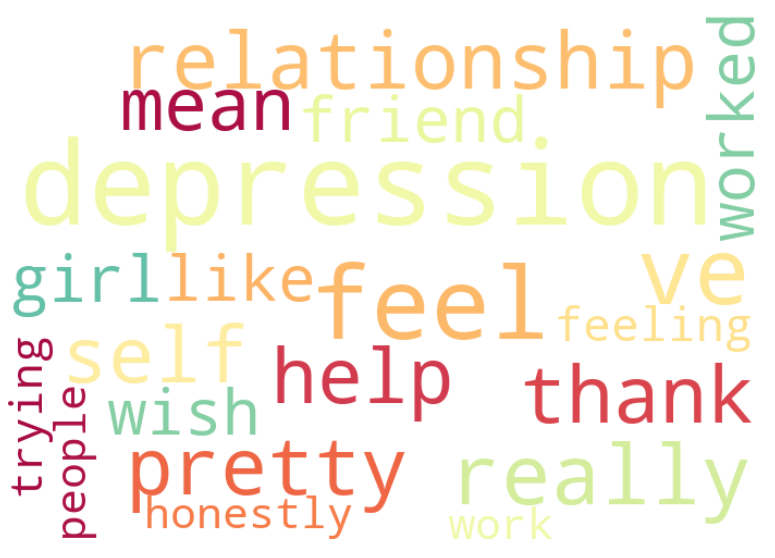

In [20]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

#generating wordclouds
plt.figure(figsize=(15,10))
wordCloud = WordCloud(width=700, height=500, max_words=50, colormap='Spectral', background_color="white")
img = wordCloud.generate_from_frequencies(good_freq)
wordCloud.to_file('undepressive_bigrams.jpg')
plt.imshow(img, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
# Instead of using classic Grid Search by sklearn we implemented this method to see how process progresses and what
# values work best

# Here we left out all the different ranges, dfs and cs's we experimented with. 
ngram_ranges = [(2, 2)]
max_dfs = [1.0, 0.98]
min_dfs = [1, 0.1, 0.05, 0.01]
cs = [0.5, 1, 2, 3]

maxi = 0.0
for ngram_range in ngram_ranges:
    print(ngram_range)
    for max_df in max_dfs:
        for min_df in min_dfs:
            if min_df >= max_df:
                continue
            for c in cs:

                vect_word = TfidfVectorizer(max_features=7500000, lowercase=True, analyzer='word',
                                        stop_words='english',ngram_range=ngram_range,dtype=np.float32, max_df=max_df, min_df=min_df)
                classifier = LogisticRegression(class_weight='balanced', max_iter=200000, solver = 'liblinear', C=c, random_state=100, n_jobs=8)
                text_clf_lr = Pipeline([('tfidf', vect_word), ('fwer', Forwarder()), ('clf', classifier)])
                text_clf_lr.fit(X_train_n['text_lem'], Y_train)
                predictions = text_clf_lr.predict(X_test_n['text_lem'])
                ac = f1_score(predictions, Y_test)
                if ac >= maxi:
                    maxi = ac
                    print(ngram_range, max_df, min_df, c)
                    print(ac)